In [7]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pnd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_validation import KFold
from itertools import product
from collections import Counter
import itertools
import inspect

In [8]:
arr = np.genfromtxt('data/chips.csv', delimiter=',')
xs, ys = arr[:,:2].copy(), np.int32(arr[:, 2:].ravel())

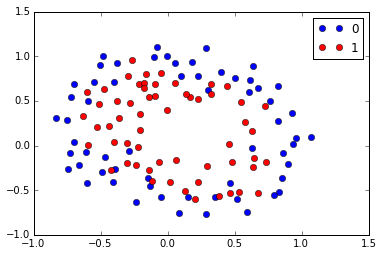

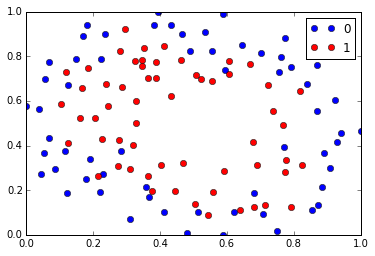

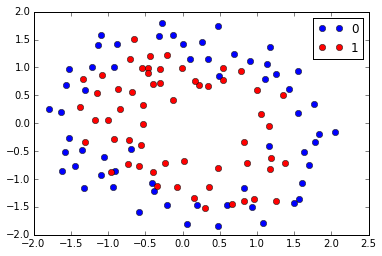

In [9]:
def show(xs, ys):
    label0, = plt.plot(xs[ys==0][:, 0], xs[ys==0][:, 1], 'bo')
    label1, = plt.plot(xs[ys==1][:, 0], xs[ys==1][:, 1], 'ro')
    plt.legend([label0, label1], ['0', '1'])
    plt.show()
show(xs, ys)

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(xs)
show(x_scaled, ys)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(xs)
show(x_scaled, ys)

In [10]:
# http://stats.stackexchange.com/questions/44166/kernelised-k-nearest-neighbour
import sklearn.metrics.pairwise as pw

def knn(x, data, labels, k, weight_f='uniform', metric_f='l2', transform_f='id', scaler=None, **params):
    if transform_f == 'id':
        transform_f = lambda x: x
    if weight_f == 'uniform':
        weight_f = lambda x: x/x
    if type(metric_f) is str:
        if metric_f.startswith('minkowski') and len(metric_f) > len('minkowski'):
            params['p'] = int(metric_f[9:])
            metric_f = 'minkowski'
        metric = metric_f
        metric_f = lambda x, y: pw.pairwise_distances([x, y], metric=metric, **params)[0, 1]
    if scaler is not None:
        x = scaler.transform(x.reshape(1, -1)).ravel()
        data = scaler.transform(data)
    mapped_x = transform_f(x)
    f = lambda t: metric_f(mapped_x, transform_f(t))
    arr = np.apply_along_axis(f, 1, data)
    neighbors = np.argsort(arr)[:k]
    neighbors_scores = weight_f(arr[neighbors])
    neighbors_labels = labels[neighbors]
    counter = Counter()
    for l, w in zip(neighbors_labels, neighbors_scores):
        counter[l] += w
    return max(counter.keys(), key=counter.get)

In [11]:
def f1_score(predicted, true):
    tp = ((predicted == true) * (predicted == 1)).sum()
    fp = ((predicted != true) * (predicted == 1)).sum()
    fn = ((predicted != true) * (predicted == 0)).sum()
    p = tp*1.0/(tp+fp)
    r = tp*1.0/(tp+fn)
    return 2*p*r/(p+r)
    

def print_args(func):
    def func_wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        to_str = lambda x: x.__name__ if callable(x) else str(x)
        print("Parameters: ", ", ".join(
                [str(x) + "=" + str(y) for x, y in zip(func.__code__.co_varnames[2:len(args)], args[2:])] + 
                [str(key) + "=" + to_str(value) for key, value in kwargs.items()]))
        print("Result: ", str(result))
        print("-"*50)
        return result
    return func_wrapper

@print_args
def kf_cross_validation(xs, ys, n_fold=10, measure='accuracy', times=1, **params):
    if measure == 'accuracy':
        measure = lambda x, y: (x==y).sum() * 1.0/len(x)
    res = 0
    for _ in range(times):
        kf = KFold(len(xs), n_fold, True)
        kf_sum = 0
        for train_i, test_i in kf:
            classifier = lambda x: knn(x, xs[train_i], ys[train_i], **params)
            true_labels = ys[test_i]
            predicted_labels = np.apply_along_axis(classifier, 1, xs[test_i])
            kf_sum += measure(predicted_labels, true_labels)
        res += kf_sum/n_fold
    return res/times

In [12]:
def transform1(x):
    return np.array([x[0], x[1], 2*x[0]*x[1], x[0]**2, x[1]**2])

def transform2(x):
    return np.array([x[0], x[1], x[0]**2, x[1]**2, x[0]**3, x[1]**3])

def transform3(x):
    return np.array([x[0]**2, x[1]**2, x[0]**3, x[1]**3, x[0] * x[1], 3*x[0]**2*x[1], 3*x[0]*x[1]**2])

def weight1(x):
    return x/x

def weight2(x):
    return 1./x

def weight3(x):
    return 1./x**2

In [17]:
ks = [x for x in range(2, 11)]
scalers = [StandardScaler().fit(xs), MinMaxScaler().fit(xs)][:1]
weight_fs = [weight1, weight2, weight3][:1]
transform_fs = ['id', transform1, transform2, transform3][:1]
metric_fs = ['l2', 'manhattan', 'minkowski3', 'minkowski4'][:1]
best_score = 0
best_args = None
for k, scaler, weight_f, transform_f, metric_f in itertools.product(
    ks, scalers, weight_fs, transform_fs, metric_fs):
    params = {'k': k, 'scaler': scaler, 'weight_f': weight_f, 'transform_f': transform_f, 'metric_f': metric_f}
    score = kf_cross_validation(xs, ys, n_fold=10, times=5, **params)
    if score > best_score:
        best_score = score
        best_args = params
        
print('BEST:')
score = kf_cross_validation(xs, ys, n_fold=10, times=5, **best_args)

Parameters:  transform_f=id, times=5, k=2, weight_f=weight1, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), n_fold=10, metric_f=l2
Result:  0.668484848485
--------------------------------------------------
Parameters:  transform_f=id, times=5, k=3, weight_f=weight1, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), n_fold=10, metric_f=l2
Result:  0.754090909091
--------------------------------------------------
Parameters:  transform_f=id, times=5, k=4, weight_f=weight1, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), n_fold=10, metric_f=l2
Result:  0.699242424242
--------------------------------------------------
Parameters:  transform_f=id, times=5, k=5, weight_f=weight1, scaler=StandardScaler(copy=True, with_mean=True, with_std=True), n_fold=10, metric_f=l2
Result:  0.745757575758
--------------------------------------------------
Parameters:  transform_f=id, times=5, k=6, weight_f=weight1, scaler=StandardScaler(copy=True, with_mean=

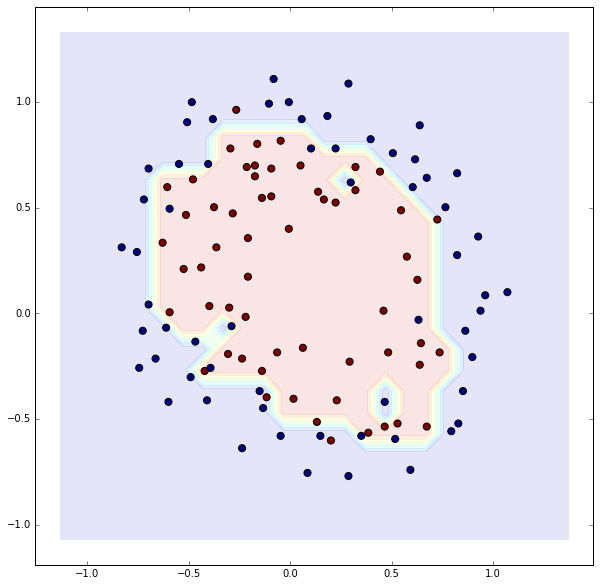

In [70]:
def show_knnspace(xs, ys, **params):
    x_min, x_max = xs[:, 0].min() - 0.3, xs[:, 0].max() + 0.3
    y_min, y_max = xs[:, 1].min() - 0.3, xs[:, 1].max() + 0.3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    plt.figure(figsize=(10,10))
    classifier = lambda x: knn(x, xs, ys, **params)          
    Z = np.apply_along_axis(classifier, 1, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.1)
    plt.scatter(xs[:, 0], xs[:, 1], s=50, c=ys)
    plt.show()
show_knnspace(xs,  ys, **best_args)